In [1]:
import os, sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

import torch

import gym

import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append('/Users/kanoumotoharu/Desktop/machine_learning/強化学習/実験コード/RL_algorithms/DQN/')
from agent import  Agent
sys.path.append('/Users/kanoumotoharu/Desktop/machine_learning/強化学習/実験コード/RL_algorithms/Memory/')
from PrioritizedExperienceMemory import ProportionalReplayMemory
from Memory import Replay_Memory
from PrioritizedExperienceMemoryNsplit import ProportionalReplayNsplitMemory

In [3]:
class Environment:
    def __init__(self):
        self.step=0
    
    def get_state(self, env, obs):
        env_low = env.observation_space.low 
        env_high = env.observation_space.high 
        # normalize
        state = (obs - env_low)/(env_high - env_low)
        return [self.step]+state.tolist()

    def get_reward(self, env, next_obs, reward):
        low = env.observation_space.low[0]
        high = env.observation_space.high[0]
        reward = float((next_obs[0]-low)/(high-low))
        reward = 2*reward-1
        d = np.log1p(self.step)+1
        if next_obs[0]>=env.observation_space.high[0]-0.2:
            reward+=200/d
            
        return reward
    
    def get_action(self,env, action):
        action = int(action)
        return action

    def get_data(self, env, obs, next_obs, reward, action):
        state = self.get_state(env, obs)
        next_state = self.get_state(env, next_obs)
        reward = self.get_reward(env, next_obs, reward)
        action = self.get_action(env, action)
        self.step+=1
        return state, action, next_state, reward

In [4]:
#make env
env = gym.make('MountainCar-v0')

In [40]:
action_space = env.action_space.n
environment = Environment()
replay_memory = ProportionalReplayNsplitMemory(2000, n=10)
agent = Agent(action_space=action_space, input_size=3, nSplit=True, weight_decay=0.00001, hidden_layers=[10,20])

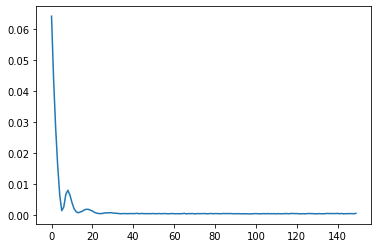

In [41]:
# 楽観的初期化
loss_list = agent.init_param_optim(150, env, environment)
plt.plot(loss_list)

In [42]:
actions = []
rewards = []
loss = []

In [44]:
# 10000エピソードで学習する
for episode in tqdm(range(60)):
    total_reward = 0
    observation = env.reset()
    environment = Environment()
    replay_memory.ResetTemporalMemory()
    
    for _ in range(1500):
        #env.render()
        
        # ε-グリーディ法で行動を選択        
        now_state = environment.get_state(env, observation)
        now_state = torch.FloatTensor(now_state)
        action =  agent.get_action(now_state)
        actions.append(action)
        
        #環境を取得
        next_observation, reward, done, _ = env.step(action)        
        #optim parameters
        state, action, next_state, reward = environment.get_data(env, observation, next_observation, reward, action)
        
        replay_memory.push(state, action, next_state, reward)
        _loss = agent.update_agent(replay_memory)
        
        total_reward += reward
        
        if _loss is not None:
            loss.append(_loss)
        observation = next_observation
        if observation[0]>=env.observation_space.high[0]-0.001:
            break
    rewards.append(total_reward)

In [45]:
#env.close()

In [46]:
#torch.save( agent.policy_net.state_dict(), 'state_dict.pt')

<AxesSubplot:ylabel='Density'>

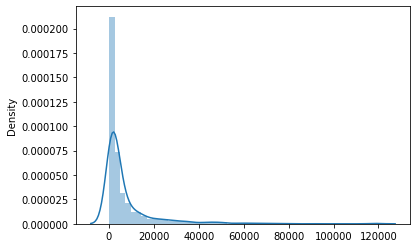

In [47]:
sns.distplot(replay_memory.priority)

In [48]:
#replay_memory.memory

In [49]:
loss_df = pd.DataFrame(loss, columns=['loss'])
reward_df = pd.DataFrame(rewards, columns=['reward'])
action_df = pd.DataFrame(actions, columns=['action'])

loss_df['loss_r30'] = loss_df['loss'].rolling(30,min_periods=1).mean()
reward_df['reward_r30'] = reward_df['reward'].rolling(30,min_periods=1).mean()
action_df['action'] = action_df['action'].map({0:"push left", 1:"no push", 2:"push right"})

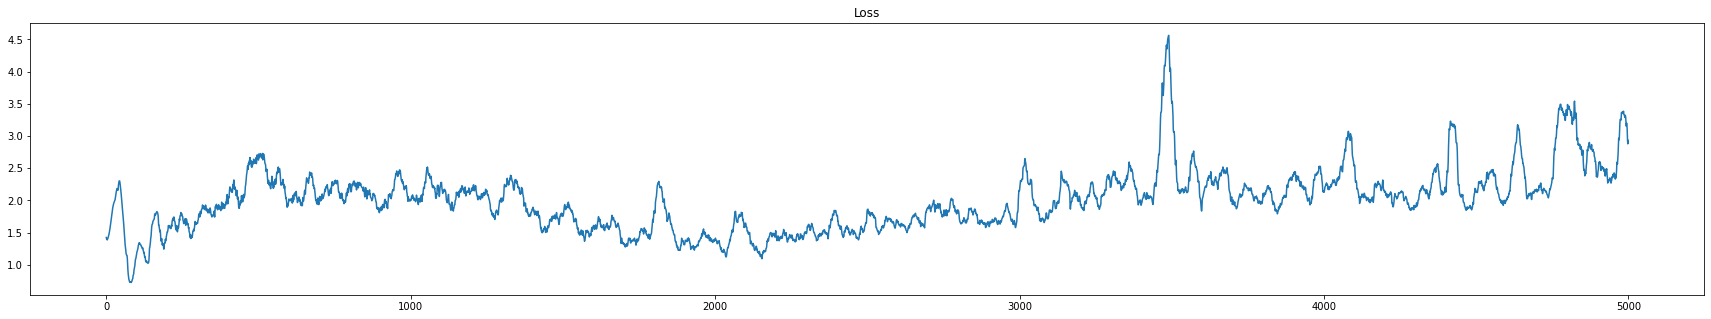

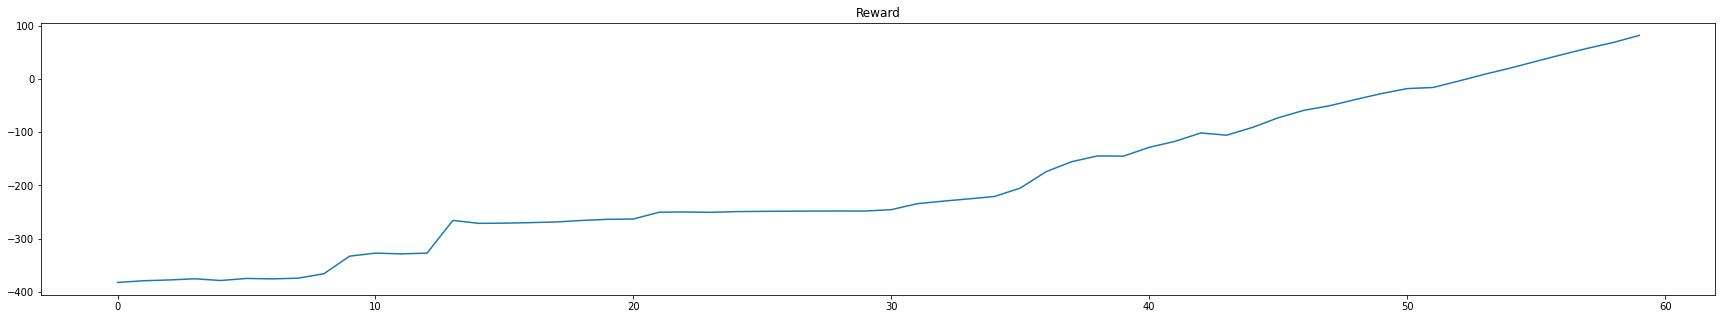

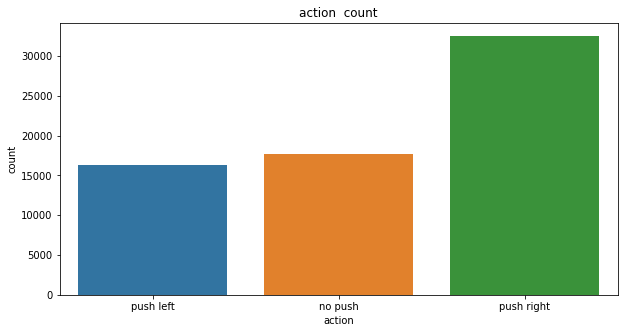

In [50]:
plt.figure(figsize=(30,5))
plt.plot(loss_df['loss_r30'][:5000])
plt.title('Loss')
plt.show()

plt.figure(figsize=(30,5))
plt.plot(reward_df['reward_r30'])
plt.title('Reward')
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(action_df["action"], order=["push left", "no push","push right"])
plt.title("action  count")
plt.show()

In [52]:
# 10000エピソードで学習する
result_rewards=[]
for episode in range(10):
    total_reward = 0
    observation = env.reset()
    for _ in range(2000):
        env.render()
        
        # ε-グリーディ法で行動を選択        
        now_state = environment.get_state(env, observation)
        now_state = torch.FloatTensor(now_state)
        action =  agent.get_action(now_state)

        next_observation, reward, done, _ = env.step(action)
        state, action, next_state, reward = environment.get_data(env, observation, next_observation, reward, action)
        
        total_reward += reward
        observation = next_observation
        if observation[0]>=env.observation_space.high[0]-0.001:
            break
    result_rewards.append(total_reward)
env.close()

KeyboardInterrupt: 

In [33]:
env.close()